# Extracting Transistor Electrical Characteristics

In this notebook, we seek to extract

- maximum storage tempurature
- minimum storage tempurature
- polarity
- maximum collector emitter voltage
- maximum emitter base voltage
- maximum collector current
- total device dissipation
- minimum dc gain



In [1]:
%load_ext autoreload
%autoreload 1
%matplotlib inline
import os
import sys
import logging

# To allow importing from the general utils
sys.path.insert(0, "..")

# Configure logging for Fonduer
logging.basicConfig(
    stream=sys.stdout,
    format="[%(levelname)s] %(name)s:%(lineno)s - %(message)s",
    level=logging.INFO,
)
logger = logging.getLogger(__name__)

# See https://docs.python.org/3/library/os.html#os.cpu_count
PARALLEL = len(os.sched_getaffinity(0))
COMPONENT = "transistors"
conn_string = "postgresql://localhost:5432/" + COMPONENT

In [2]:
# If you've run this before, set FIRST_TIME to False to save time
FIRST_TIME = True

In [3]:
from fonduer import Meta

session = Meta.init(conn_string).Session()

[INFO] fonduer.meta:86 - Connecting user:None to localhost:5432/transistors
[INFO] fonduer.meta:110 - Initializing the storage schema


In [4]:
from utils import parse_dataset
docs, train_docs, dev_docs, test_docs = parse_dataset(session, first_time=FIRST_TIME, max_docs=100, parallel=PARALLEL)
logger.info(f"# of train Documents:\t{len(train_docs)}")
logger.info(f"# of dev Documents:\t{len(dev_docs)}")
logger.info(f"# of test Documents:\t{len(test_docs)}")

[INFO] utils.utils:37 - Parsing dataset...
[INFO] utils.utils:39 - Parsing dev...
[INFO] fonduer.utils.udf:57 - Running UDF...



[INFO] utils.utils:39 - Parsing test...
[INFO] fonduer.utils.udf:57 - Running UDF...



[INFO] utils.utils:39 - Parsing train...
[INFO] fonduer.utils.udf:57 - Running UDF...



[INFO] __main__:3 - # of train Documents:	100
[INFO] __main__:4 - # of dev Documents:	100
[INFO] __main__:5 - # of test Documents:	75


In [5]:
from fonduer.parser.models import Document, Section, Paragraph, Sentence, Figure

logger.info(f"Documents:\t{session.query(Document).count()}")
logger.info(f"Sections:\t{session.query(Section).count()}")
logger.info(f"Paragraphs:\t{session.query(Paragraph).count()}")
logger.info(f"Sentences:\t{session.query(Sentence).count()}")
logger.info(f"Figures:\t{session.query(Figure).count()}")

[INFO] __main__:3 - Documents:	275
[INFO] __main__:4 - Sections:	275
[INFO] __main__:5 - Paragraphs:	136992
[INFO] __main__:6 - Sentences:	141638
[INFO] __main__:7 - Figures:	7440


# Phase 2: Mention Extraction, Candidate Extraction Multimodal Featurization

Given the unified data model from Phase 1, `Fonduer` extracts relation
candidates based on user-provided **matchers** and **throttlers**. Then,
`Fonduer` leverages the multimodality information captured in the unified data
model to provide multimodal features for each candidate.

## 2.1 Mention Extraction

The first step is to extract **mentions** from our corpus. A `mention` is the
type of object which makes up a `candidate`. For example, if we wanted to
extract pairs of transistor part numbers and their corresponding maximum
storage temperatures, the transistor part number would be one `mention` while
the temperature value would be another. These `mention`s are then combined to
create `candidates`, where our task is to predict which `candidates` are true
in the associated document.

We first start by defining and naming our two `mention`s:

In [6]:
from fonduer.candidates.models import mention_subclass

Part = mention_subclass("Part")
Temp = mention_subclass("Temp")

In [7]:
from transistor_matchers import get_matcher
temp_matcher = get_matcher("temp")

In [8]:
part_matcher = get_matcher("part")

These two matchers define each entity in our relation schema.

### Define a Mention's `MentionSpace`

Next, in order to define the "space" of all mentions that are even considered
from the document, we need to define a `MentionSpace` for each component of the
relation we wish to extract. Fonduer provides a default `MentionSpace` for you
to use, but you can also extend the default `MentionSpace` depending on your
needs.

In the case of transistor part numbers, the `MentionSpace` can be quite complex
due to the need to handle implicit part numbers that are implied in text like
"BC546A/B/C...BC548A/B/C", which refers to 9 unique part numbers. To handle
these, we consider all n-grams up to 3 words long.

In contrast, the `MentionSpace` for temperature values is simpler: we only need
to process different Unicode representations of a (`-`), and don't need to look
at more than two words at a time.

When no special preprocessing like this is needed, we could have used the
default `Ngrams` class provided by `fonduer`. For example, if we were looking
to match polarities, which only take the form of "NPN" or "PNP", we could've
used `ngrams = MentionNgrams(n_max=1)`.

In [9]:
from transistor_spaces import MentionNgramsPart, MentionNgramsTemp
    
part_ngrams = MentionNgramsPart(parts_by_doc=None, n_max=3)
temp_ngrams = MentionNgramsTemp(n_max=2)

### Running Mention Extraction 

Next, we create a `MentionExtractor` to extract the mentions from all of
our documents based on the `MentionSpace` and matchers we defined above.

View the API for the MentionExtractor on [ReadTheDocs](https://fonduer.readthedocs.io/en/latest/user/candidates.html#fonduer.candidates.MentionExtractor).


In [10]:
from fonduer.candidates import MentionExtractor 

mention_extractor = MentionExtractor(
    session, [Part, Temp], [part_ngrams, temp_ngrams], [part_matcher, temp_matcher]
)

Then, we run the extractor on all of our documents.

In [11]:
from fonduer.candidates.models import Mention

if FIRST_TIME:
    mention_extractor.apply(docs, parallelism=PARALLEL)

logger.info(f"Total Mentions: {session.query(Mention).count()}")

[INFO] fonduer.candidates.mentions:460 - Clearing table: part
[INFO] fonduer.candidates.mentions:460 - Clearing table: temp
[INFO] fonduer.utils.udf:57 - Running UDF...



[INFO] __main__:6 - Total Mentions: 9378


## 2.2 Candidate Extraction

Now that we have both defined and extracted the Mentions that can be used to compose Candidates, we are ready to move on to extracting Candidates. Like we did with the Mentions, we first define what each candidate schema looks like. In this example, we create a candidate that is composed of a `Part` and a `Temp` mention as we defined above. We name this candidate "PartTemp".

In [12]:
from fonduer.candidates.models import candidate_subclass

PartTemp = candidate_subclass("PartTemp", [Part, Temp])

### Defining candidate `Throttlers`

Next, we need to define **throttlers**, which allow us to further prune excess candidates and avoid unnecessarily materializing invalid candidates. Throttlers, like matchers, act as hard filters, and should be created to have high precision while maintaining complete recall, if possible.

Here, we create a throttler that discards candidates if they are in the same table, but the part and storage temperature are not vertically or horizontally aligned.

In [13]:
from transistor_throttlers import stg_temp_filter

temp_throttler = stg_temp_filter

### Running the `CandidateExtractor`

Now, we have all the component necessary to perform candidate extraction. We have defined the Mentions that compose each candidate and a throttler to prunes away excess candidates. We now can define the `CandidateExtractor` with the candidate subclass and corresponding throttler to use.

View the API for the CandidateExtractor on [ReadTheDocs](https://fonduer.readthedocs.io/en/docstrings/user/candidates.html#fonduer.candidates.CandidateExtractor).

In [14]:
from fonduer.candidates import CandidateExtractor


candidate_extractor = CandidateExtractor(session, [PartTemp], throttlers=[temp_throttler])

Here we specified that these `Candidates` belong to the training set by specifying `split=0`; recall that we're referring to train/dev/test as splits 0/1/2.

In [15]:
if FIRST_TIME:
    for i, docs in enumerate([train_docs, dev_docs, test_docs]):
        candidate_extractor.apply(docs, split=i, parallelism=PARALLEL)
        logger.info("Number of Candidates in split={}: {}".format(i, session.query(PartTemp).filter(PartTemp.split == i).count()))

train_cands = candidate_extractor.get_candidates(split = 0)
dev_cands = candidate_extractor.get_candidates(split = 1)
test_cands = candidate_extractor.get_candidates(split = 2)

logger.info(f"Total train candidate:\t{len(train_cands[0])}")
logger.info(f"Total dev candidate:\t{len(dev_cands[0])}")
logger.info(f"Total test candidate:\t{len(test_cands[0])}")

[INFO] fonduer.candidates.candidates:125 - Clearing table part_temp (split 0)
[INFO] fonduer.utils.udf:57 - Running UDF...



[INFO] __main__:4 - Number of Candidates in split=0: 76751
[INFO] fonduer.candidates.candidates:125 - Clearing table part_temp (split 1)
[INFO] fonduer.utils.udf:57 - Running UDF...



[INFO] __main__:4 - Number of Candidates in split=1: 43473
[INFO] fonduer.candidates.candidates:125 - Clearing table part_temp (split 2)
[INFO] fonduer.utils.udf:57 - Running UDF...



[INFO] __main__:4 - Number of Candidates in split=2: 8045
[INFO] __main__:10 - Total train candidate:	76751
[INFO] __main__:11 - Total dev candidate:	43473
[INFO] __main__:12 - Total test candidate:	8045


## 2.2 Multimodal Featurization
Unlike dealing with plain unstructured text, `Fonduer` deals with richly formatted data, and consequently featurizes each candidate with a baseline library of multimodal features. 

### Featurize with `Fonduer`'s optimized Postgres Featurizer
We now annotate the candidates in our training, dev, and test sets with features. The `Featurizer` provided by `Fonduer` allows this to be done in parallel to improve performance.

View the API provided by the `Featurizer` on [ReadTheDocs](https://fonduer.readthedocs.io/en/latest/user/features.html#fonduer.features.Featurizer).

In [16]:
from fonduer.features import Featurizer

featurizer = Featurizer(session, [PartTemp])
if FIRST_TIME:
    %time featurizer.apply(split=0, train=True, parallelism=PARALLEL)
    %time featurizer.apply(split=1, parallelism=PARALLEL)
    %time featurizer.apply(split=2, parallelism=PARALLEL)

%time F_train = featurizer.get_feature_matrices(train_cands)
%time F_dev = featurizer.get_feature_matrices(dev_cands)
%time F_test = featurizer.get_feature_matrices(test_cands)

logger.info(f"Train shape:\t{F_train[0].shape}")
logger.info(f"Test shape:\t{F_test[0].shape}")
logger.info(f"Dev shape:\t{F_dev[0].shape}")

[INFO] fonduer.features.featurizer:189 - Clearing Features (split 0)
[INFO] fonduer.utils.udf:57 - Running UDF...



CPU times: user 2.28 s, sys: 248 ms, total: 2.52 s
Wall time: 8min 58s
[INFO] fonduer.features.featurizer:189 - Clearing Features (split 1)
[INFO] fonduer.utils.udf:57 - Running UDF...



CPU times: user 1.7 s, sys: 223 ms, total: 1.92 s
Wall time: 5min 5s
[INFO] fonduer.features.featurizer:189 - Clearing Features (split 2)
[INFO] fonduer.utils.udf:57 - Running UDF...



CPU times: user 907 ms, sys: 206 ms, total: 1.11 s
Wall time: 2min 15s
CPU times: user 2min 2s, sys: 6.13 s, total: 2min 8s
Wall time: 2min 50s
CPU times: user 1min 4s, sys: 3.27 s, total: 1min 8s
Wall time: 1min 30s
CPU times: user 13.3 s, sys: 666 ms, total: 14 s
Wall time: 18.1 s
[INFO] __main__:13 - Train shape:	(76751, 17223)
[INFO] __main__:14 - Test shape:	(8045, 17223)
[INFO] __main__:15 - Dev shape:	(43473, 17223)


In [17]:
from transistor_utils import load_hardware_labels, TRUE, FALSE, ABSTAIN

if FIRST_TIME:
    load_hardware_labels(session, PartTemp, "stg_temp_max" ,annotator_name='gold')

[INFO] transistor_utils:85 - Loading 128269 candidate labels



[INFO] transistor_utils:115 - GoldLabels created: 128269


In [18]:
from fonduer.supervision import Labeler
from transistor_lfs import stg_temp_lfs

labeler = Labeler(session, [PartTemp])
if FIRST_TIME:
    %time labeler.apply(split=0, lfs=[stg_temp_lfs], train=True, parallelism=PARALLEL)
%time L_train = labeler.get_label_matrices(train_cands)

[INFO] fonduer.supervision.labeler:232 - Clearing Labels (split 0)
[INFO] fonduer.utils.udf:57 - Running UDF...



CPU times: user 2.65 s, sys: 343 ms, total: 2.99 s
Wall time: 47min 46s
CPU times: user 1min 40s, sys: 5.31 s, total: 1min 46s
Wall time: 2min 19s


In [19]:
from fonduer.supervision import get_gold_labels
L_gold_train = get_gold_labels(session, train_cands, annotator_name='gold')

In [20]:
from metal import analysis

analysis.lf_summary(L_train[0], lf_names=labeler.get_keys(), Y=L_gold_train[0].todense().reshape(-1,).tolist()[0])

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
LabelKey (LF_collector_aligned),0,1,0.041993,0.041993,0.001433,3223,0,1.0
LabelKey (LF_complement_left_row),1,1,0.000495,0.000495,0.000130,38,0,1.0
LabelKey (LF_current_aligned),2,1,0.429532,0.429532,0.011857,32967,0,1.0
LabelKey (LF_negative_number_left),3,2,0.040208,0.040208,0.040208,0,3086,0.0
LabelKey (LF_not_temp_relevant),4,1,0.931871,0.931871,0.001590,71522,0,1.0
LabelKey (LF_operating_row),5,2,0.049042,0.049042,0.049042,0,3764,0.0
LabelKey (LF_storage_row),6,2,0.060703,0.060703,0.060703,0,4659,0.0
LabelKey (LF_temperature_row),7,2,0.054097,0.054097,0.054097,0,4152,0.0
LabelKey (LF_temp_on_high_page_num),8,1,0.620292,0.620292,0.009407,47608,0,1.0
LabelKey (LF_temp_outside_table),9,1,1.000000,1.000000,0.069719,76751,0,1.0


### Fitting the Generative Model

Now, we'll train a model of the LFs to estimate their accuracies. Once the model is trained, we can combine the outputs of the LFs into a single, noise-aware training label set for our extractor. Intuitively, we'll model the LFs by observing how they overlap and conflict with each other. To do so, we use [MeTaL](https://github.com/HazyResearch/metal)'s single-task label model.

In [21]:
from metal.label_model import LabelModel

gen_model = LabelModel(k=2)
%time gen_model.train_model(L_train[0], n_epochs=500, print_every=100)

Computing O...
Estimating \mu...
[E:0]	Train Loss: 4.653
[E:100]	Train Loss: 0.054
[E:200]	Train Loss: 0.049
[E:300]	Train Loss: 0.049
[E:400]	Train Loss: 0.049
[E:499]	Train Loss: 0.049
Finished Training
CPU times: user 774 ms, sys: 29 ms, total: 803 ms
Wall time: 446 ms


We now apply the generative model to the training candidates to get the noise-aware training label set. We'll refer to these as the training marginals:

In [22]:
train_marginals = gen_model.predict_proba(L_train[0])

We'll look at the distribution of the training marginals:

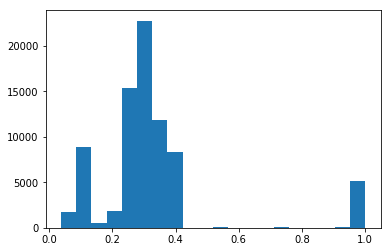

In [23]:
import matplotlib.pyplot as plt
plt.hist(train_marginals[:, TRUE - 1], bins=20)
plt.show()

We can view the learned accuracy parameters as well.

In [24]:
# gen_model.weights.lf_accuracy
L_train[0].shape

(76751, 16)

### Using the Model to Iterate on Labeling Functions

Now that we have learned the generative model, we can stop here and use this to potentially debug and/or improve our labeling function set. First, we apply the LFs to our development set:

In [25]:
labeler.apply(split=1, lfs=[stg_temp_lfs], parallelism=PARALLEL)
%time L_dev = labeler.get_label_matrices(dev_cands)

[INFO] fonduer.supervision.labeler:232 - Clearing Labels (split 1)
[INFO] fonduer.utils.udf:57 - Running UDF...



CPU times: user 55 s, sys: 2.64 s, total: 57.7 s
Wall time: 1min 14s


In [26]:
L_dev[0].shape

(43473, 16)

### Interpreting Generative Model Performance

At this point, we should be getting an F1 score of around 0.6 to 0.7 on the development set, which is pretty good! However, we should be very careful in interpreting this. Since we developed our labeling functions using this development set as a guide, and our generative model is composed of these labeling functions, we expect it to score very well here!

In fact, it is probably somewhat overfit to this set. However this is fine, since in the next, we'll train a more powerful end extraction model which will generalize beyond the development set, and which we will evaluate on a blind test set (i.e. one we never looked at during development).


### Training the Discriminative Model

Now, we'll use the noisy training labels we generated in the last part to train our end extraction model. For this tutorial, we will be training a simple--but fairly effective--logistic regression model.

We use the training marginals to train a discriminative model that classifies each Candidate as a true or false mention. 

In [27]:
from fonduer.learning import LogisticRegression

disc_model = LogisticRegression()
%time disc_model.train((train_cands[0], F_train[0]), train_marginals, n_epochs=50, lr=0.001)

[INFO] fonduer.learning.classifier:98 - Loading default parameters for Logistic Regression
[INFO] fonduer.learning.classifier:195 - Settings: {'n_epochs': 50, 'lr': 0.001, 'batch_size': 256, 'shuffle': True, 'seed': 1234, 'host_device': 'CPU', 'bias': False, 'input_dim': 17223}
[INFO] fonduer.learning.classifier:213 - [LogisticRegression] Training model
[INFO] fonduer.learning.classifier:215 - [LogisticRegression] n_train=76751 #epochs=50 batch size=256
[INFO] fonduer.learning.classifier:262 - [LogisticRegression] Epoch 1 (131.65s)	Average loss=0.539063
[INFO] fonduer.learning.classifier:262 - [LogisticRegression] Epoch 5 (649.07s)	Average loss=0.531981
[INFO] fonduer.learning.classifier:262 - [LogisticRegression] Epoch 10 (1294.31s)	Average loss=0.532132
[INFO] fonduer.learning.classifier:262 - [LogisticRegression] Epoch 15 (1939.50s)	Average loss=0.532280
[INFO] fonduer.learning.classifier:262 - [LogisticRegression] Epoch 20 (2586.03s)	Average loss=0.532214
[INFO] fonduer.learning.cl

In [28]:
import numpy as np
from transistor_utils import entity_level_f1
import pickle
pickle_file = 'data/parts_by_doc_dict.pkl'
with open(pickle_file, 'rb') as f:
    parts_by_doc = pickle.load(f)

Now, we score using the discriminitive model:

In [29]:
test_score = disc_model.predict((test_cands[0], F_test[0]), b=0.6, pos_label=TRUE)
true_pred = [test_cands[0][_] for _ in np.nditer(np.where(test_score == TRUE))]
%time (TP, FP, FN) = entity_level_f1(true_pred, "stg_temp_max", test_docs, parts_by_doc=parts_by_doc)

[INFO] fonduer.learning.classifier:354 - Using positive label class 2 with threshold 0.6
[INFO] transistor_utils:151 - Preparing candidates...



[INFO] transistor_utils:172 - ========================================
[INFO] transistor_utils:173 - Scoring on Entity-Level Gold Data
[INFO] transistor_utils:174 - ========================================
[INFO] transistor_utils:175 - Corpus Precision 0.522
[INFO] transistor_utils:176 - Corpus Recall    0.856
[INFO] transistor_utils:177 - Corpus F1        0.649
[INFO] transistor_utils:178 - ----------------------------------------
[INFO] transistor_utils:179 - TP: 131 | FP: 120 | FN: 22
[INFO] transistor_utils:180 - ========================================

CPU times: user 4.86 s, sys: 185 ms, total: 5.04 s
Wall time: 6.37 s


We can see that there are actually only a few documents that are causing us problems. In particular, we see that `BC546-D` is giving us many false positives. So, let's inspect one of those candidates. 

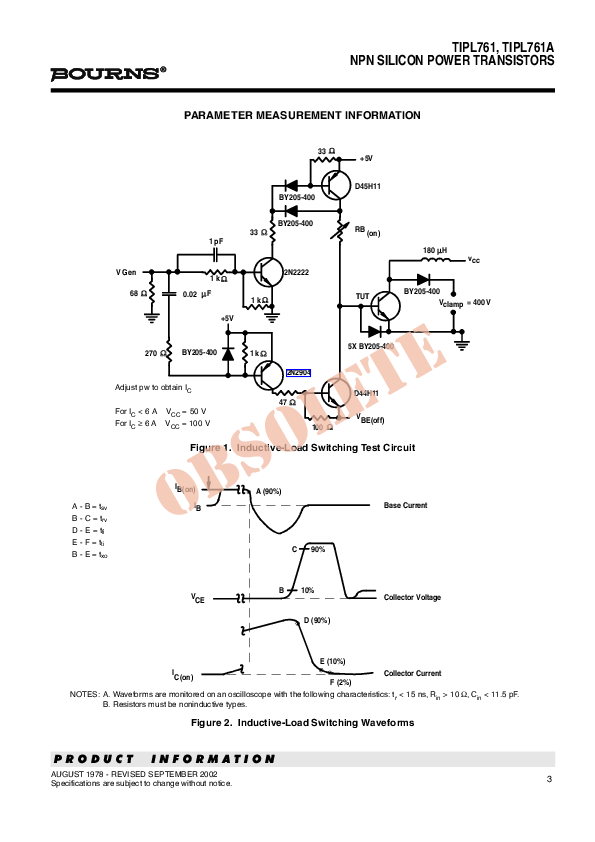

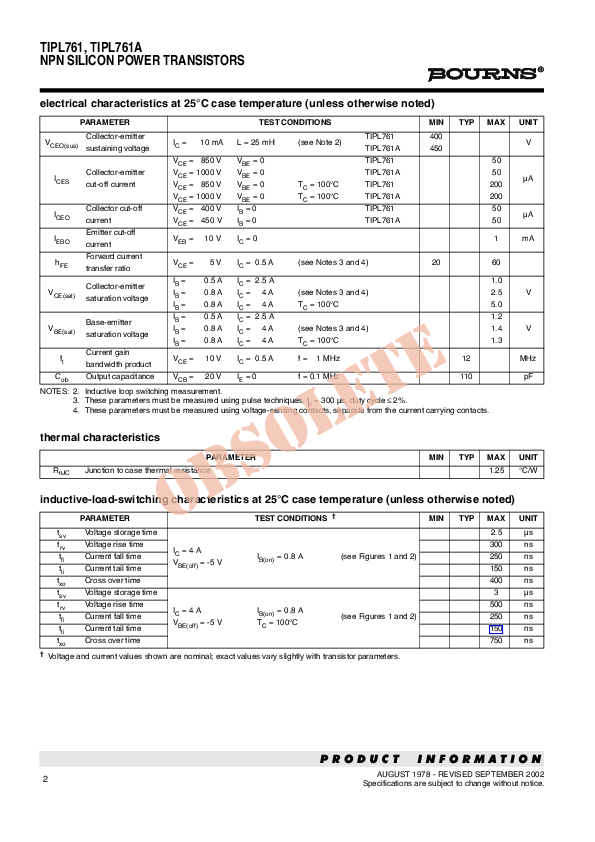

In [30]:
from fonduer.utils.visualizer import Visualizer
from transistor_utils import entity_to_candidates
vis = Visualizer("data/test/pdf")

# Get a list of candidates that match the FN[10] entity
fp_cands = entity_to_candidates(FP[1], test_cands[0])
# Display a candidate
vis.display_candidates([fp_cands[0]])